In [2]:
import anndata as ad
import scanpy as sc

from scmiac.scmiac import find_anchors,preprocess,train_model,model_inference
from scmiac.preprocess import run_umap

In [3]:
adata_rna_file = "../../demo_data/adata_rna_10x.h5ad"
adata_atac_file = "../../demo_data/adata_atac_10x.h5ad"

device = "cuda:2"

In [4]:
adata_rna = sc.read(adata_rna_file)
print(adata_rna)
adata_atac = sc.read(adata_atac_file)
print(adata_atac)

AnnData object with n_obs × n_vars = 10412 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'modality'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 10412 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'modality', 'pred'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_umap', 'lsi49', 'lsi49_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [5]:
anchor_df = find_anchors(
    adata_rna,
    adata_atac,
    mode='v'
)

Directly using 10412 pairing cells as anchors


In [6]:
rna_vae, atac_vae, all_cells_loader, anchor_cells_loader = preprocess(
    adata_rna, 
    adata_atac,
    anchor_df,
    rna_latent_key = "X_pca",
    atac_latent_key = "lsi49",
    device = device)

In [7]:
rna_vae, atac_vae = train_model(
    rna_vae, 
    atac_vae, 
    all_cells_loader, 
    anchor_cells_loader, 
    device = device, 
    num_epoches = 2000,
    print_step = 100)

Epoch 0, Total: 3319.08, RNA Reco: 1006.51, RNA KLD: 0.29, ATAC Reco: 987.15, ATAC KLD: 0.27, Contra: 1324.86
Epoch 100, Total: 1679.04, RNA Reco: 234.47, RNA KLD: 66.04, ATAC Reco: 220.47, ATAC KLD: 67.95, Contra: 1090.11
Epoch 200, Total: 1470.03, RNA Reco: 123.26, RNA KLD: 75.47, ATAC Reco: 108.67, ATAC KLD: 76.09, Contra: 1086.55
Epoch 300, Total: 1429.18, RNA Reco: 104.78, RNA KLD: 77.05, ATAC Reco: 87.64, ATAC KLD: 77.83, Contra: 1081.88
Epoch 400, Total: 1415.05, RNA Reco: 98.41, RNA KLD: 77.47, ATAC Reco: 80.60, ATAC KLD: 78.49, Contra: 1080.08
Epoch 500, Total: 1407.60, RNA Reco: 95.00, RNA KLD: 77.63, ATAC Reco: 77.04, ATAC KLD: 78.45, Contra: 1079.49
Epoch 600, Total: 1402.31, RNA Reco: 92.58, RNA KLD: 77.86, ATAC Reco: 74.68, ATAC KLD: 78.58, Contra: 1078.60
Epoch 700, Total: 1398.98, RNA Reco: 91.04, RNA KLD: 77.91, ATAC Reco: 73.07, ATAC KLD: 78.60, Contra: 1078.35
Epoch 800, Total: 1395.99, RNA Reco: 89.93, RNA KLD: 77.89, ATAC Reco: 71.92, ATAC KLD: 78.51, Contra: 1077.

In [8]:
rna_embeddings, atac_embeddings = model_inference(
    rna_vae, 
    atac_vae, 
    all_cells_loader)

In [9]:
adata_rna.obsm['scmiac_latent'] = rna_embeddings
adata_atac.obsm['scmiac_latent'] = atac_embeddings

In [10]:
adata_cm = ad.concat([adata_rna, adata_atac],join='outer')

/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
adata_cm = run_umap(adata_cm,'scmiac_latent')

UMAP embedding is stored in adata.obsm['scmiac_latent_umap']


/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/txm/miniforge3/envs/scMIAAC/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


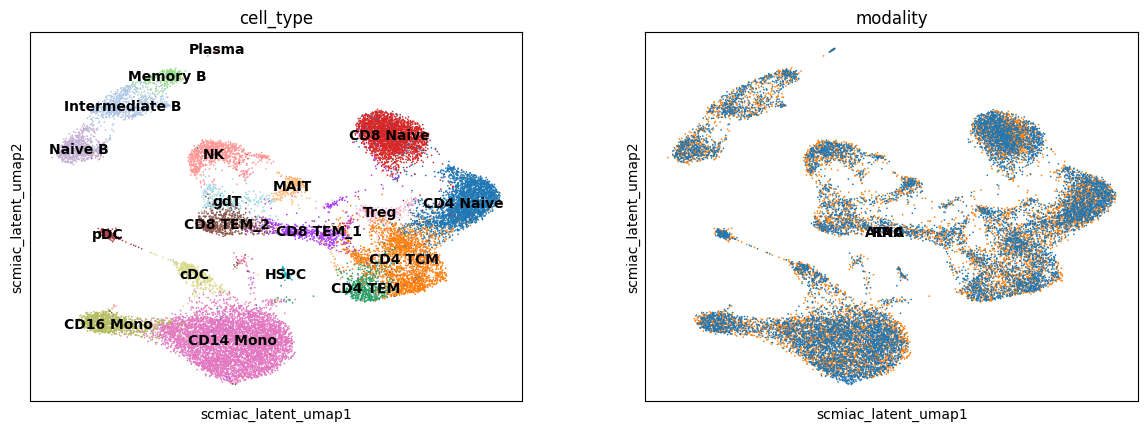

In [12]:
sc.pl.embedding(adata_cm, basis='scmiac_latent_umap', color=['cell_type','modality'],legend_loc = 'on data')